In [4]:
! pip install d2l==1.00a0 --quiet



#### TO SKIP CELL %%script echo skipping

     |████████████████████████████████| 92 kB 1.1 MB/s 


In [5]:
import os
import hashlib
import tarfile
import zipfile
import requests
import time
import math
import random
import re
import collections
import inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from IPython import display
from d2l import torch as d2l
from torch.distributions.multinomial import Multinomial
from torch import nn
from torch.nn import functional as F
from torchvision import transforms


plt.style.use("Solarize_Light2")

In [6]:
get_src = lambda x: print(inspect.getsource(x))

# **Initial Practice**

## **Pandas Practice**

In [7]:
f = lambda x: 3*x **2 - 4*x

In [8]:
os.makedirs(os.path.join('..','data'),exist_ok=True)
data_file = os.path.join('..', 'data', 'house_tiny.csv')

with open(data_file,'w') as f:
  f.write('''NumRooms,RoofType,Price
NA,NA,127500
2,NA,106000
4,Slate,178100
NA,NA,14000''')

## **Plotting with SVG**

In [9]:
%matplotlib inline
from matplotlib_inline import backend_inline

In [10]:
def use_svg_display():
  backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):  
    """Set the figure size for matplotlib."""
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize


In [11]:
def set_axes(axes, xlabel,ylabel, xlim, ylim, xscale, yscale,legend):
  axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
  axes.set_xscale(xscale), axes.set_yscale(yscale)
  axes.set_xlim(xlim), axes.set_ylim(ylim)
  if legend:
    axes.legend(legend)
  axes.grid()

In [12]:
def plot(X, Y=None, xlabel=None, ylabel=None, legend=[],
         xlim=None,ylim=None,xscale='linear',yscale='linear',
         fmts=('-','m--','g-.','r:'),figsize=(3.5,2.5),axes=None):
  """Plot data points"""
  def has_one_axis(X): #true if X has 1 axis (tensor, list)
    return ((hasattr(X,"ndim") and X.ndim == 1) or 
            (isinstance(X,list) and not hasattr(X[0],"__len__")))
  
  if has_one_axis(X): X = [X]

  if Y is None:
    X,Y = [[]]*len(X),X
  elif has_one_axis(Y):
    Y = [Y]
  
  if len(X) != len(Y):
    X = X*len(Y)
  
  set_figsize(figsize)
  if axes is None: axes = d2l.plt.gca()
  axes.cla()

  for x,y,fmt in zip(X,Y,fmts): 
    axes.plot(x,y,fmt) if len(x) else axes.plot(y,fmt)
  set_axes(axes,xlabel,ylabel,xlim,ylim,xscale,yscale,legend)


In [13]:
#plot(x, [f(x), 2 * x - 3], 'x', 'f(x)', legend=['f(x)', 'Tangent line (x=1)'])

In [14]:
#x = torch.arange(4.0, requires_grad=True)

In [15]:
#fair_probs=torch.tensor([0.2,0.8])
#Multinomial(100,fair_probs).sample()

# **An Object Oriented Interface for Deep Learning**

## **Adding functions as class methods using a decorator**

In [16]:
def add_to_class(my_class):
  """A decorator for adding a method to a class after definition."""
  def add_attribute(func):
    """Decorator adds the attribute func to the class."""
    setattr(my_class,func.__name__,func)
  return add_attribute




In [17]:
class Hyperparameters:
  def save_hyperparameters(self,ignore=[]):
    raise NotImplemented

In [18]:
@add_to_class(Hyperparameters)
def save_hyperparameters(self,ignore=[]):
  """Save function arguments into class attributes."""
  frame = inspect.currentframe().f_back
  _,_,_, local_vars = inspect.getargvalues(frame)
  self.hparams = {k:v for k, v in local_vars.items()
                  if k not in set(ignore+['self']) and not k.startswith('_')}
  for k,v in self.hparams.items():
    setattr(self,k,v)

In [19]:
class B(Hyperparameters):
  def __init__(self,a,b,c):
    self.save_hyperparameters(ignore=['c'])
    print('self.a =', self.a, 'and self.b =', self.b)
    print("There is no self.c =", not hasattr(self,'c'))

#b = B(a=1,b=2,c=3)

## **A Tensorboard-lite class that plots data points in animation**

In [20]:
class ProgressBoard(Hyperparameters):
  """Plot data points in animation."""
  def __init__(self,xlabel=None, ylabel=None, xlim=None, ylim=None,
               xscale='linear', yscale='linear', ls=['-', '--', '-.', ':'],
               colors=['C0','C1','C2','C3'], fig=None, axes=None,
               figsize=(3.5,2.5), display=True):
    self.save_hyperparameters()

  def draw(self,x,y,label,every_n=1):
    raise NotImplemented

In [21]:
@add_to_class(ProgressBoard)
def draw(self,x,y,label,every_n=1):
  Point = collections.namedtuple('Point',['x','y'])
  if not hasattr(self, 'raw_points'):
    self.raw_points = collections.OrderedDict()
    self.data = collections.OrderedDict() #for every label like "val_loss" we have a collection of points to plot
  if label not in self.raw_points:
    self.raw_points[label] = []
    self.data[label] = []
  points = self.raw_points[label]
  line = self.data[label]
  points.append(Point(x,y))


  if len(points) != every_n:
    return
  mean = lambda x : sum(x)/len(x)
  line.append(Point(mean([p.x for p in points]),
              mean([p.y for p in points])))

  points.clear()
  if not self.display:
    return
  use_svg_display()
  if self.fig is None:
    self.fig = plt.figure(figsize=self.figsize)
  plt_lines, labels = [], []
  for (k,v), ls, color in zip(self.data.items(), self.ls, self.colors):
    plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                              linestyle=ls, color=color)[0])
    labels.append(k)
  axes = self.axes if self.axes else plt.gca()
  if self.xlim: axes.set_xlim(self.xlim)
  if self.ylim: axes.set_ylim(self.ylim)
  if not self.xlabel: 
    #print("Currently here and self.x = ", self.x)
    self.xlabel = self.x
  axes.set_xlabel(self.xlabel)
  axes.set_ylabel(self.ylabel)
  axes.set_xscale(self.xscale)
  axes.set_yscale(self.yscale)
  axes.legend(plt_lines, labels)
  display.display(self.fig)
  display.clear_output(wait=True)

In [22]:
#board = ProgressBoard('x',display=True)
#for x in np.arange(0,10,0.1):
#  board.draw(x,np.sin(x), 'sin', every_n=10)
#  board.draw(x,np.cos(x),'cos', every_n=4)

## **The Main classes: `Module, DataModule and Trainer`**

The `Module` class is our main model for neural networks. Any future architecture we create will invoke this class. During initialization, it accepts the `plot_train_per_epoch` and `plot_valid_per_epoch` parameters. It has access to a `ProgressBoard` object for plotting loss during training, as well as a `Trainer` object. It has a `loss` function to calculate the loss between predictions `y_hat` and truth `y`, a `forward` function, a `plot` function that plots one point in animation (taking `

In [23]:
class Module(nn.Module,Hyperparameters):
  def __init__(self, plot_train_per_epoch=2,
               plot_valid_per_epoch=1):
    super().__init__()
    self.save_hyperparameters()
    self.board = ProgressBoard()

  def loss(self, y_hat, y):
    raise NotImplementedError
  
  def forward(self, X):
    assert hasattr(self,'net'), 'Neural Network is not defined'
    return self.net(X)

  def plot(self,key,value,train):
    """Plot a point in animation."""
    assert hasattr(self,'trainer'), "Trainer is not inited"
    self.board.xlabel = 'epoch'
    if train:
      x = self.trainer.train_batch_idx / \
          self.trainer.num_train_batches
      n = self.trainer.num_train_batches / \
          self.plot_train_per_epoch
    else:
      x = self.trainer.epoch + 1
      n = self.trainer.num_val_batches / \
          self.plot_valid_per_epoch
    self.board.draw(x, value.to(torch.device('cpu')).detach().numpy(),
                    ('train_' if train else 'val_') + key,
                    every_n=int(n))
  def training_step(self,batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    self.plot('loss',l,train=True)
    return l
  
  def validation_step(self,batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    self.plot('loss',l,train=False)

  def configure_optimizers(self):
    raise NotImplementedError

The `DataModule` class's job is to get the training and validation dataloaders from the `root` filepath `../data`. The main function is `get_dataloader(self,train)` where `train` is a boolean that is `True` when we want the train dataloader and `False` otherwise.

In [24]:
class DataModule(Hyperparameters):
  def __init__(self, root='../data', num_workers=4):
    self.save_hyperparameters()

  def get_dataloader(self,train):
    raise NotImplementedError
  
  def train_dataloader(self):
    return self.get_dataloader(train=True)

  def val_dataloader(self):
    return self.get_dataloader(train=False)

The `Trainer` class's job is to train the model for `self.max_epochs` number of epochs. For this purpose it has a `self.fit(model, data)` object that takes in `Module` and `DataModule` objects. It then picks out the training and validation dataloaders from `DataModule` and configures the optimizers in the `Module` object. Then it fits one step each epoch using the `self.fit_epoch` function.

In [25]:
class Trainer(Hyperparameters):
  def __init__(self,max_epochs,num_gpus=0,
               gradient_clip_val=0):
    self.save_hyperparameters()
    assert num_gpus == 0, 'No GPU support yet'

  def prepare_data(self,data):
    self.train_dataloader = data.train_dataloader()
    self.val_dataloader = data.val_dataloader()
    self.num_train_batches = len(self.train_dataloader)
    self.num_val_batches = (len(self.val_dataloader)
                            if self.val_dataloader is not None
                            else 0)
    
  def prepare_model(self,model):
    model.trainer = self
    model.board.xlim = [0,self.max_epochs]
    self.model = model

  def fit(self,model,data):
    self.prepare_data(data)
    self.prepare_model(model)
    self.optim = model.configure_optimizers()
    self.epoch = 0
    self.train_batch_idx = 0
    self.val_batch_idx = 0
    for self.epoch in range(self.max_epochs):
      self.fit_epoch()

  def fit_epoch(self):
    raise NotImplementedError

# **Chapter 3-4. Linear Neural Networks for Regression and Classification**

## **Synthetic Data**

In [26]:
class SyntheticRegressionData(DataModule):
  def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32): #y = Xw + b + noise
    super().__init__()
    self.save_hyperparameters()
    n = num_train+num_val
    self.X = torch.randn(n,len(w))
    noise = torch.randn(n,1) * noise
    self.y = self.X@w.reshape((-1,1)) + b + noise
      

In [27]:
#data = SyntheticRegressionData(w=torch.tensor([2,-3.4]), b=4.2)

In [28]:
#data.X[0], data.y[0]

In [29]:
@add_to_class(SyntheticRegressionData)
def get_dataloader(self,train): #yields training or validation batches
  #X has shape n_t + n_v by d y has shape n_t + n_v
  if train:
    indices = list(range(0,self.num_train))
    random.shuffle(indices)
  else:
    indices= list(range(self.num_train, self.num_train + self.num_val))
  for i in range(0,len(indices),self.batch_size):
    batch_indices = torch.tensor(indices[i:i+self.batch_size])
    yield self.X[batch_indices], self.y[batch_indices]

In [30]:
#X,y = next(iter(data.train_dataloader()))

In [31]:
@add_to_class(DataModule)
def get_tensorloader(self, tensors, train, indices=slice(0,None)):
  tensors = tuple(a[indices] for a in tensors)
  dataset = torch.utils.data.TensorDataset(*tensors)
  return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)


@add_to_class(SyntheticRegressionData)
def get_dataloader(self,train):
  i = slice(0, self.num_train) if train else slice(self.num_train, None)
  return self.get_tensorloader((self.X, self.y), train, i)

In [32]:
#len(data.train_dataloader())

## **The `LinearRegressionScratch` Module**

In [33]:
class LinearRegressionScratch(Module):
  def __init__(self, num_inputs, lr, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
    self.b = torch.zeros(1, requires_grad=True)

In [34]:
@add_to_class(LinearRegressionScratch)
def forward(self, x):
  return x@self.w + self.b

In [35]:
@add_to_class(LinearRegressionScratch)
def loss(self,y_hat,y):
  return ((y_hat - y.reshape(y_hat.shape))**2).mean()

## **The `SGD` Class**

In [36]:
class SGD(Hyperparameters):
  def __init__(self,params, lr):
    self.save_hyperparameters()

  def step(self):
    with torch.no_grad():
      for param in self.params:
        param -= self.lr * param.grad

  def zero_grad(self):
    for param in self.params:
      param.grad.zero_()


In [37]:
@add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
  return SGD([self.w,self.b],self.lr)

In [38]:
@add_to_class(Trainer)
def prepare_batch(self, batch):
  return batch

@add_to_class(Module)
def train(self, mode=True):
  if not isinstance(mode,bool):
    raise ValueError("training mode should be boolean")
  self.training = mode
  for module in self.children():
    module.train(mode)
  return self

@add_to_class(Module)
def eval(self):
  return self.train(False)



## **The `Trainer.fit_epoch` function**

In each **epoch** we iterate through the entire training dataset. In each iteration, we grab a mini-batch of training examples, compute its loss through the model's `training_step` method, and then compute the gradients with respect to each parameter. Then we update the model parameters

In [39]:
@add_to_class(Trainer)
def fit_epoch(self):
  self.model.train()

  #self.train_batch_idx = 0

  for batch in self.train_dataloader:
    #compute loss by self.model.training_step()
    loss = self.model.training_step(self.prepare_batch(batch)) 
    loss.backward()
    if self.gradient_clip_val > 0:
      self.clip_gradients(self.gradient_clip_val, self.model)
    self.optim.step()
    self.optim.zero_grad()
    self.train_batch_idx += 1

  if self.val_dataloader is None:
    return

  self.model.eval()

  #self.val_batch_idx = 0
  for batch in self.val_dataloader:
    with torch.no_grad():
      self.model.validation_step(self.prepare_batch(batch))
    self.val_batch_idx += 1




In [40]:
#model = LinearRegressionScratch(2,lr=0.03)
#data = SyntheticRegressionData(w=torch.tensor([2,-3.4]),b=4.2)
#trainer = Trainer(max_epochs=3)

#trainer.fit(model, data)

## **Linear Regression using the high-level APIs of PyTorch**

In [41]:
class LinearRegression(Module):
  def __init__(self, lr):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.LazyLinear(1)
    self.net.weight.data.normal_(mean=0,std=0.01)
    self.net.bias.data.fill_(0)

In [42]:
@add_to_class(LinearRegression)
def forward(self,x):
  return self.net(x)

In [43]:
@add_to_class(LinearRegression)
def loss(self,y_hat,y):
  fn = nn.MSELoss()
  return fn(y_hat,y)

In [44]:
@add_to_class(LinearRegression)
def configure_optimizers(self):
  return torch.optim.SGD(self.parameters(),self.lr)

In [45]:
#model = LinearRegression(lr=0.03)
#data = SyntheticRegressionData(w=torch.tensor([2,-3.4]),b=4.2)
#trainer = Trainer(max_epochs=4)
#trainer.fit(model,data)

In [46]:
@add_to_class(LinearRegression)
def get_w_b(self):
  return (self.net.weight.data, self.net.bias.data)

#w,b = model.get_w_b()

In [47]:
#print(f"w = {w} \nand b = {b}")


## **Weight Decay**

In [48]:
class Data(DataModule):
  def __init__(self, num_train, num_val,num_inputs, batch_size):
    self.save_hyperparameters()
    n = num_train + num_val
    self.X = torch.randn(n, num_inputs)
    noise = torch.randn(n,1) * 0.01
    w, b = torch.ones((num_inputs,1))*0.01, 0.05
    self.y =  self.X @ w + b + noise

  def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.X,self.y], train, i)

In [49]:
def l2_penalty(w):
  return (w ** 2).sum()/2

In [50]:
class WeightDecayScratch(LinearRegressionScratch):
  def __init__(self, num_inputs, lambd, lr, sigma=0.01):
    super().__init__(num_inputs, lr, sigma)
    self.save_hyperparameters()

  def loss(self, y_hat,y):
    return super().loss(y_hat,y) + self.lambd * l2_penalty(self.w)

In [51]:
#data = Data(num_train=20,num_val=100,num_inputs=200, batch_size=5)
#trainer = Trainer(max_epochs=10)

def train_scratch(lambd):
  model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
  model.board.yscale='log'
  trainer.fit(model,data)
  print("L2 norm of w: ", float(l2_penalty(model.w)))

#train_scratch(3.5)

In [52]:
class WeightDecay(LinearRegression):
  def __init__(self, wd, lr):
    super().__init__(lr)
    self.save_hyperparameters()
    self.wd = wd

  def configure_optimizers(self):
    return torch.optim.SGD(self.net.parameters(),
                           lr=self.lr, weight_decay=self.wd)

In [53]:
#model = WeightDecay(wd=3, lr=0.01)
#model.board.yscale='log'
#trainer.fit(model,data)


## **The Fashion MNIST Dataset**

In [54]:
class FashionMNIST(DataModule):
  def __init__(self, batch_size=64,resize=(28,28)):
    super().__init__()
    self.save_hyperparameters()
    trans = transforms.Compose([
                                transforms.Resize(resize),
                                transforms.ToTensor()
    ])
    self.train = torchvision.datasets.FashionMNIST(
        root=self.root, train=True, transform=trans, download=True
    )
    self.val = torchvision.datasets.FashionMNIST(
        root=self.root, train=False, transform=trans, download=True
    )

In [55]:
#data = FashionMNIST(resize=(32,32))

In [56]:
@add_to_class(FashionMNIST)
def text_labels(self, indices):
  labels = ['t-shirt', 'trouser', 'pullover', 'dress','coat',
            'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return [labels[int(i)] for i in indices]


In [57]:
@add_to_class(FashionMNIST)
def get_dataloader(self, train):
  data = self.train if train else self.val
  return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                     num_workers=self.num_workers)


In [58]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = plt.subplots(num_rows, num_cols,figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    try:
      img = img.detach().numpy()
    except:
      pass
    ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles:
      ax.set_title(titles[i])
  return axes



In [59]:
@add_to_class(FashionMNIST)
def visualize(self, batch, nrows=2, ncols=4,labels=[]):
  X, y = batch
  if not labels:
    labels = self.text_labels(y)
  show_images(X.squeeze(1), nrows, ncols, titles=labels)

#batch = next(iter(data.val_dataloader()))
#data.visualize(batch)

## **The Base Classification Model**

In [60]:
class Classifier(Module):
  def validation_step(self, batch):
    Y_hat = self(*batch[:-1]) #__call__ calls foward
    self.plot("loss", self.loss(Y_hat, batch[-1]), train=False)
    self.plot("acc", self.accuracy(Y_hat, batch[-1]), train=False)



In [61]:
@add_to_class(Module)
def configure_optimizers(self):
  return torch.optim.SGD(self.parameters(), lr=self.lr)

In [62]:
@add_to_class(Classifier)
def accuracy(self, Y_hat, Y, averaged=True):
  Y_hat = Y_hat.reshape( (-1, Y_hat.shape[-1]))
  preds = Y_hat.argmax(axis=1).type(Y.dtype)
  compare = (preds == Y.reshape(-1)).type(torch.float32)
  return compare.mean() if averaged else compare

In [63]:
#X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
#X.sum(0, keepdims=True), X.sum(1, keepdims=True)

In [64]:
def softmax(x):
  x_exp = torch.exp(x)
  return x_exp/x_exp.sum(dim=1,keepdims=True)

In [65]:
class SoftmaxRegressionScratch(Classifier):
  def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.W = torch.normal(0, sigma, size = (num_inputs, num_outputs), 
                          requires_grad=True)
    self.b = torch.zeros(num_outputs, requires_grad=True)
  
  def parameters(self):
    return [self.W, self.b]

In [66]:
@add_to_class(SoftmaxRegressionScratch)
def forward(self, x):
  return softmax(x.reshape((-1,self.W.shape[0])) @ self.W + self.b)

In [67]:
#y = torch.tensor([0,2])
#y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
#y_hat[[0,1],y]

In [68]:
def cross_entropy(y_hat,y):
  return - torch.log(y_hat[range(len(y_hat)), y]).mean()

#cross_entropy(y_hat, y)

In [69]:
@add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
  return cross_entropy(y_hat, y)

In [70]:
#data = FashionMNIST(batch_size=256)
#model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
#trainer = Trainer(max_epochs=10)
#trainer.fit(model, data)

In [71]:
#I want to do MNIST Classification.
#For any task I need a model (the architecture),
#I need a DataModule and I need a Trainer object
#The DataModule gives me train and test dataloaders
#The Trainer object has a fit function that sets things up
#Returns a loss function, and for max_epochs, it does a training step
#Each training step, for each batch in the train data loader
#compute the loss, call backward(), gradient clip if need be
#optim.step(), optim.zero_grad(), train_batch_idx += 1
# and then take a training and valdiation step
# the training step calculuates the loss and plots the loss
# to the progressboard
# I don't understand the x_axis in the train and validation steps.
#where does it decide that what should be x axis should be

In [72]:
#a = torch.tensor([[3,2],[1,1],[0,4]])
#a.argmax(axis=1)

## **Concise Softmax Regression**

In [73]:
class SoftmaxRegression(Classifier):
  def __init__(self, num_outputs, lr):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.Flatten(),
        nn.LazyLinear(num_outputs)
    )

So we have $$\frac{\exp t_k}{\sum_j \exp t_j} = \frac{\exp (t_k-\overline{t})\exp \overline{t}}{\sum_j \exp(t_j - \overline{t}) \exp\overline{t}} = \frac{\exp (t_k - \overline{t})}{\sum_j \exp(t_j - \overline{t})}$$ This helps with numerical overflows.

By calculating the log softmax $\log \circ \sigma$

In [74]:
@add_to_class(SoftmaxRegression)
def loss(self, y_hat, y, averaged=True):
  y_hat = y_hat.reshape((-1, y_hat.shape[-1]))
  y = y.reshape((-1,))
  return F.cross_entropy(y_hat, y, reduction='mean' if averaged else 'none')

In [75]:
#data = FashionMNIST(batch_size=256)
#model = SoftmaxRegression(num_outputs=10, lr=0.1)
#trainer = Trainer(max_epochs=10)
#trainer.fit(model, data)

## **Environment and Distribution Shift**



### **Covariate Shift**

Assume that we want to estimate the probability distribution over the labels $y$ given input $\mathbf{x}$. That is, we are trying to estimate $p(y\mid \mathbf{x})$ given labelled data points $(\mathbf{x}_i, y_i)$. When we have a *covariate shift*, the observations are drawn from some source distribution $q(\mathbf{x})$ rather than the target distribution $p(\mathbf{x})$ such that $p(y \mid \mathbf{x}) = q(y \mid \mathbf{x})$ still holds.



We can correct for this by using the following simple identity in the risk: 

$$
\int \int \ell(f(\mathbf{x}, y) p(y \mid \mathbf{x}) p(\mathbf{x}) d\mathbf{x}\,dy  = \int\int \ell(f(\mathbf{x}, y) q(y \mid \mathbf{x})q(\mathbf{x})\frac{p(\mathbf{x})}{q(\mathbf{x})} d\mathbf{x}\,dy
$$



In other words, we need to reweight each data example by the ratio that it would have been drawn from the correct distribution to that from the wrong one: $$\beta_i := \frac{p(\mathbf{x_i})}{q(\mathbf{x}_i)}$$ So we can train our model using *weighted empirical risk minimization* where we minimize $\frac{1}{n} \sum_{i=1}^{n} \beta_i \ell(f(\mathbf{x}_i, y_i))$.

However, we don't know this ratio, so we need to estimate it. Many methods are available, including some fancy operator-theoretic approaches that attempt to recalibrate the expecation operator directly using a minimum-norm or a maximum entropy principle. Note that for any such approach, we need samples drawn from both distributions -- the "true" $p$ (access to the test data), and the training $q$. Note that however, we only need features $\mathbf{x} \sim p(\mathbf{x})$ and not labels $y \sim \mathbf{p}(y)$.

In this case there exists an effective approach that will give almost as good results: logistic regression for binary classification. This is a special case of softmax regression.

We learn a classifier to distinguish between data drawn from $p(\mathbf{x})$ and data drawn from $q(\mathbf{x})$. If it is impossible to distinguish between the two distributions then it means that the associated instnaces are equally likely to come from either one of the two distributions. 

Let $z$ be a variable representing the label of a point $\mathbf{x}$. We will use logistic regression to estimate $P(z=1 \mid \mathbf{x}) = \sigma(h(\mathbf{x}))$ (by a choice of $h$). If we do so, then $\beta_i = \frac{P(z = 1\mid \mathbf{x})}{P(z = -1 \mid \mathbf{x})} = \exp(h(\mathbf{x}_i))$. Generally, we take $\beta_i = \min \exp(h(\mathbf{x}_i), c)$

This algorithm relies on a crucial assumption. We need that each data example during test time had a nonzero probability of occuring at training time. If we find a point where $p(\mathbf{x}) > 0$ but $q(\mathbf{x}) = 0$, then the assigned weight should be infinity. 

### **Label Shift Correction**

Assume that we are dealing with a classfication task with $k$ categories. Assume now that the class conditional distribution stays the same $q(\mathbf{x} \mid y) = p(\mathbf{x} \mid y)$. Now we can use a similar identity as before, and our importance weights will correspond to the label likelihood ratios $\beta_i = \frac{p(y_i)}{q(y_i)}$

We have $\sum_{j=1}^{k} c_{ij} p(y_j) = \mu(\hat{y}_i)$ where $\mu(\hat{y}_i)$ is the fraction of total predictions on the test set where our model predicted $i$, $c_{ij}$ is the fraction of total predictions on the validation set where the true label was $j$ and our model predicted $i$, and $p(y_j)$ is the true probability of label $y_j$.



# **Chapter 5. Multilayer Perceptrons**



One activation function is the parameterized ReLU function `pReLU` defined by $\verb|pReLU|(x) = \max(0,x) + \alpha \min(0,x) = \begin{cases} x &\text{ if } x > 0 \\ \alpha x &\text{ if } x \leq 0 \end{cases}$. This has derivative $\alpha$ if $x \leq 0$ and $1$ if $x > 0$.

## **MLP from scratch**

In [76]:
class MLPScratch(Classifier):
  def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens)*sigma)
    self.b1 = nn.Parameter(torch.zeros(num_hiddens))
    self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs)*sigma)
    self.b2 = nn.Parameter(torch.zeros(num_outputs))

In [77]:
def relu(x):
  a = torch.zeros_like(x)
  return torch.max(x,a)

In [78]:
@add_to_class(MLPScratch)
def forward(self,x):
  x = x.reshape((-1, self.num_inputs))
  h = relu(x @ self.W1 + self.b1)
  return h@self.W2 + self.b2

In [79]:
@add_to_class(Classifier)
def loss(self, y_hat, y,averaged=True):
  #print(f"Previously, y_hat shape was {y_hat.shape}")
  y_hat = y_hat.reshape((-1,y_hat.shape[-1]))
  y = y.reshape((-1,))
  #print(f"y_hat shape is {y_hat.shape} and y shape is {y.shape}")
  return F.cross_entropy(y_hat, y, reduction='mean' if averaged else 'none')

In [80]:
#model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
#data = FashionMNIST(batch_size=256)
#trainer = Trainer(max_epochs=10)
#trainer.fit(model, data)

In [81]:
class MLP(Classifier):
  def __init__(self, num_outputs, num_hiddens, lr):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.Flatten(), 
        nn.LazyLinear(num_hiddens),
        nn.ReLU(),
        nn.LazyLinear(num_outputs)
    )

In [82]:
#model = MLP(num_outputs=10, num_hiddens=256,lr=0.1)
#trainer.fit(model, data)

## **Dropout**



In [83]:
def dropout_layer(X, dropout):
  assert 0 <= dropout <= 1

  if dropout == 1:
    return torch.zeros_like(X)
  mask = (torch.rand(X.shape) > dropout).float()
  return mask * X / (1.0 - dropout)

In [84]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))


dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  0.,  0.,  6.,  0., 10.,  0., 14.],
        [16., 18.,  0., 22., 24., 26.,  0.,  0.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [85]:
class DropoutMLPScratch(Classifier):
  def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
               dropout_1, dropout_2, lr):
    super().__init__()
    self.save_hyperparameters()
    self.lin1 = nn.LazyLinear(num_hiddens_1)
    self.lin2 = nn.LazyLinear(num_hiddens_2)
    self.lin3 = nn.LazyLinear(num_outputs)
    self.relu = nn.ReLU()

  def forward(self, X):
    H1 = self.relu(self.lin1(X.reshape((X.shape[0],-1))))
    #print(f"X_new shape = {(X.reshape((X.shape[0],-1))).shape} and H1 has shape {H1.shape}")
    if self.training:
      H1 = dropout_layer(H1, self.dropout_1)
    H2 = self.relu(self.lin2(H1))
    #print(f"H2 has shape {H2.shape}")
    if self.training:
      H2 = dropout_layer(H2, self.dropout_2)
    H3 = self.lin3(H2)
    #print(f"H3 has shape {H3.shape}")
    return H3

In [86]:
#hparams = {'num_outputs':10, 'num_hiddens_1': 256, 'num_hiddens_2': 256,
           #'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
#model = DropoutMLPScratch(**hparams)
#data = FashionMNIST(batch_size=256)
#trainer = Trainer(max_epochs=10)
#trainer.fit(model, data)

In [87]:
class DropoutMLP(Classifier):
  def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
               dropout_1, dropout_2, lr):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
        nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
        nn.Dropout(dropout_2), nn.LazyLinear(num_outputs)
    )

In [88]:
#model = DropoutMLP(**hparams)
#trainer.fit(model, data)

# **Predicting House Prices on Kaggle**



## **Downloading Data Helper Functions**

In [89]:
DATA_HUB = dict()
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"

In [90]:
def download(url, folder="../data", sha1_hash=None):
  """Download a file to folder and return the local filepath."""
  if not url.startswith("http"):
    url, sha1_hash = DATA_HUB[url]
  os.makedirs(folder, exist_ok=True)
  fname = os.path.join(folder, url.split("/")[-1])

  #Check if hit cache
  if os.path.exists(fname) and sha1_hash:
    sha1 = hashlib.sha1()
    with open(fname, "rb") as f:
      while True:
        data = f.read(1048576)
        if not data:
          break
        sha1.update(data)
    if sha1.hexdigest() == sha1_hash:
      return fname
  
  print(f"Downloading {fname} from {url}")
  r = requests.get(url, stream=True, verify=True)
  with open(fname,"wb") as f:
    f.write(r.content)
  return fname

In [91]:
def extract(filename, folder=None):
  """Extract a zip/tar file into folder."""
  base_dir = os.path.dirname(filename)
  _, ext = os.path.splitext(filename)
  #print(f"base_dir is {base_dir}\n")

  assert ext in (".zip", ".tar", ".gz"), "Only support zip/tar files"

  if ext == ".zip":
    #print("here")
    fp = zipfile.ZipFile(filename, "r")
  else:
    fp = tarfile.open(filename, "r")
  
  if folder is None:
    folder = base_dir
  fp.extractall(folder)
  



## **Acquiring the Kaggle Dataset**

In [92]:
%%script echo skipping

import json

TOKEN = None

! pip install kaggle==1.5.12
! mkdir -p .kaggle
! mkdir -p /content & mkdir -p /content/.kaggle & mkdir -p /root/.kaggle/

with open('/content/.kaggle/kaggle.json','w') as file:
  json.dump(TOKEN, file)

! pip install --upgrade --force-reinstall --no-deps kaggle
! ls "/content/.kaggle"
! chmod 600 /content/.kaggle/kaggle.json
! cp /content/.kaggle/kaggle.json /root/.kaggle/

! kaggle config set -n path -v /content


skipping


In [93]:
%%script echo skipping


! kaggle competitions download -c house-prices-advanced-regression-techniques





skipping


In [94]:
%%script echo skipping


fname = "./competitions/house-prices-advanced-regression-techniques/house-prices-advanced-regression-techniques.zip"
extract(filename=fname)


skipping


In [95]:
KAGGLE_HOUSE_DATA_PATH = "./competitions/house-prices-advanced-regression-techniques/"

In [96]:
class KaggleHouse(DataModule):
  def __init__(self, batch_size, train=None, val=None):
    super().__init__()
    self.save_hyperparameters()
    if self.train is None:
      self.raw_train = pd.read_csv(KAGGLE_HOUSE_DATA_PATH + "train.csv")
      self.raw_val = pd.read_csv(KAGGLE_HOUSE_DATA_PATH + "test.csv")

In [97]:
%%script echo skipping


data = KaggleHouse(batch_size=64)

skipping


## **Data Preprocessing**

In [98]:
%%script echo skipping

data.raw_train.head()

skipping


In [99]:
@add_to_class(KaggleHouse)
def preprocess(self):
  # Remove the ID and label columns
  label = "SalePrice"
  features = pd.concat(
      (self.raw_train.drop(columns=["Id", label]),
       self.raw_val.drop(columns=["Id"])))
  
  #Standardize
  numeric_features = features.dtypes[features.dtypes != "object"].index
  features[numeric_features] = features[numeric_features].apply(
      lambda x:(x - x.mean())/(x.std())
  )

  #Replace NAN numerical features by 0
  features[numeric_features] = features[numeric_features].fillna(0)

  #Replace discrete features by one-hot encoding
  features = pd.get_dummies(features, dummy_na=True)

  #Save preprocessed features
  self.train = features[:self.raw_train.shape[0]].copy()
  self.train[label] = self.raw_train[label]
  self.val = features[self.raw_train.shape[0]:].copy()

In [100]:
%%script echo skipping

data = KaggleHouse(batch_size=64)
data.preprocess()
data.train.shape

skipping


In [101]:
@add_to_class(KaggleHouse)
def get_dataloader(self, train):
  label = "SalePrice"
  temp_data = self.train if train else self.val
  if label not in temp_data: return
  get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)

  #Logarithm of prices

  tensors = (get_tensor(temp_data.drop(columns=[label])),#x
             torch.log(get_tensor(temp_data[label])).reshape((-1,1))) #y
  return self.get_tensorloader(tensors, train)


In [102]:
def k_fold_data(data, k):
  rets = []
  fold_size = data.train.shape[0] //k
  for j in range(k):
    idx = range(j*fold_size, (j+1)* fold_size)
    rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                            data.train.loc[idx]))
    return rets


In [103]:
def k_fold(trainer, data, k, lr):
  val_loss, models = [], []
  for i, data_fold in enumerate(k_fold_data(data, k)):
    model = LinearRegression(lr)
    model.board.yscale = 'log'
    if i != 0: model.board.display = False #don't plot multiple folds
    trainer.fit(model, data_fold)
    val_loss.append(float(model.board.data["val_loss"][-1].y)) #add the final val_loss during this fold but don't plot it
    models.append(model) #keep track of models
  print(f"average validation log mse = {sum(val_loss)/len(val_loss)}")
  return models

In [104]:
%%script echo skipping

trainer = Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

skipping


#### **Model Improvement**

Currently, we are just doing base linear regression. We can increase the depth of the model to get a deeper fully connected network, add some regularization, as well as dropout. Also, we can tune the hyperparameters of the model: the regularization factor $\lambda$, the learning rate $\alpha$

In [105]:
class HouseModel(Module):
  def __init__(self, num_h1=256, num_h2=64, num_h3=16, num_out=1, dropout_p1=0.5, dropout_p2=0.5,dropout_p3=0.5, lr=0.1, weight_decay=1):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyLinear(num_h1), nn.ReLU(), nn.Dropout(dropout_p1),
        nn.LazyLinear(num_h2), nn.ReLU(), nn.Dropout(dropout_p2),
        nn.LazyLinear(num_h3), nn.ReLU(), nn.Dropout(dropout_p3),
        nn.LazyLinear(num_out)
    )

  def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

  def configure_optimizers(self):
      return torch.optim.Adam(self.parameters(),lr=self.lr, weight_decay=self.weight_decay)

In [106]:
print(inspect.getsource(d2l.LinearRegression.loss))

    def loss(self, y_hat, y):
        """Defined in :numref:`sec_linear_concise`"""
        fn = nn.MSELoss()
        return fn(y_hat, y)



In [107]:
%%script echo skipping


trainer = Trainer(max_epochs=50)
models2 = k_fold(trainer, data, k=5, lr=0.03)

skipping


In [108]:
def k_fold_new(trainer, data, k, lr=0.1, weight_decay=1,dropout_probs=[0.5,0.5,0.5]):
  val_loss, models = [], []
  for i, data_fold in enumerate(k_fold_data(data, k)):
    model = HouseModel(lr=lr,weight_decay=weight_decay, dropout_p1=dropout_probs[0],
                       dropout_p2=dropout_probs[1], dropout_p3=dropout_probs[2])
    model.board.yscale = 'log'
    if i != 0: model.board.display = False #don't plot multiple folds
    trainer.fit(model, data_fold)
    val_loss.append(float(model.board.data["val_loss"][-1].y)) #add the final val_loss during this fold but don't plot it
    models.append(model) #keep track of m    odels
  print(f"average validation log mse = {sum(val_loss)/len(val_loss)}")
  return models

In [109]:
#trainer = Trainer(max_epochs=180)
#models = k_fold_new(trainer, data, k=5, lr=1e-2, weight_decay=0)

In [110]:
#preds = [model(torch.tensor(data.val.values, dtype=torch.float32)) for model in models]
#ensemble_preds = torch.exp(torch.cat(preds,1)).mean(1)
#submission = pd.DataFrame({"Id":data.raw_val.Id, 
                           #"SalePrice":ensemble_preds.detach().numpy()})
#submission.to_csv("submission.csv", index=False)

In [111]:
#! kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "House Prices Dropout+3 Layers+No Tuning"


# **Chapter 6. Builders' Guide**

## **The `nn.Module` Class**

We will introduce the concept of a neural network *module*. A module could describe a single layer, a component of multiple layers, or the entire model itself. These can be combined into larger artifacts.

In [112]:
net = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))
X = torch.rand(2,20)
net(X).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 10])

`nn.Sequential` defines a special kind of `Module`, the class that presents a module in PyTorch.

In [113]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = nn.LazyLinear(256)
    self.out = nn.LazyLinear(10)

  def forward(self, x):
    return self.out(F.relu(self.hidden(x)))

In [114]:
class MySequential(nn.Module):
  def __init__(self, *args):
    super().__init__()
    for idx, module in enumerate(args):
      self.add_module(str(idx), module)

  def forward(self,x):
    for module in self.children():
      x = module(x)
    return x

Note that not all networks are simple daisy chains, and sometimes greater flexibility is required, we will want to define our own blocks. For example, we might want to execute Python's control flow.

In [115]:
class FixedHiddenMLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.rand_weight = torch.rand((20,20)) #gradients will not be computed
    self.linear = nn.LazyLinear(20)

  def forward(self,x):
    x = self.linear(x)
    x = F.relu(x @ self.rand_weight + 1)
    x = self.linear(x) #we are reusing the same fully connectd layer (sharing parameters)
    while x.abs().sum() > 1: #control flow
      x /= 2
    return x.sum()

In [116]:
class NestMLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.LazyLinear(64), nn.ReLU(),
                             nn.LazyLinear(32), nn.ReLU())
    self.linear = nn.LazyLinear(16)

  def forward(self, x):
    return self.linear(self.net(x))


chimera = nn.Sequential(NestMLP(), nn.LazyLinear(20), FixedHiddenMLP())
chimera(torch.rand(2,20))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor(0.1172, grad_fn=<SumBackward0>)

## **Parameter Management and Initialization**



When we move away from stacked architectures with standard layers, we will sometimes need to get into the weeds of declaring and manipulating parameters.

In [117]:
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(), nn.LazyLinear(1))
X = torch.rand(size=(2,4))
net(X).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 1])

When we define a model using the `nn.Sequential` class, we can access any layer by indexing into the model as if it were a list. Each layer's parameters are conveniently located in its attribute. 

In [118]:
net[2].state_dict()

OrderedDict([('weight',
              tensor([[-0.2214, -0.0441,  0.0289, -0.0787,  0.0164, -0.0658,  0.1873, -0.2876]])),
             ('bias', tensor([0.2750]))])

In [119]:
net[2].bias.data

tensor([0.2750])

`Parameters` are complex objects containing values, gradients, and additional information.

In [120]:
[(name, param.shape) for name, param in net.named_parameters()]

[('0.weight', torch.Size([8, 4])),
 ('0.bias', torch.Size([8])),
 ('2.weight', torch.Size([1, 8])),
 ('2.bias', torch.Size([1]))]

Often we want to share parameters across multiple layers. 

In [121]:
shared = nn.LazyLinear(8)
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.LazyLinear(1))
print(net(X)) #we need to call the forward pass before accessing parameters
print("*"*50)
print(net[2].weight.data[0] == net[4].weight.data[0])

net[2].weight.data[0,0] = 100
print(net[2].weight.data[0] == net[4].weight.data[0])



tensor([[-0.0337],
        [-0.0210]], grad_fn=<AddmmBackward0>)
**************************************************
tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


By default, PyTorch initializaes weights uniformly by drawing from a range that is computed according to the input and output dimensions.

In [122]:
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(), nn.LazyLinear(1))
X = torch.rand(size=(2, 4))
net(X).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 1])

In [123]:
def init_normal(module):
  if type(module) == nn.LazyLinear:
    nn.init.normal_(module.weight, mean=0, std=0.01)
    nn.init.zeros_(module.bias)
net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([ 0.1369, -0.4067,  0.3530, -0.2516]), tensor(-0.2020))

In [124]:
def init_constant(module):
  if type(module) == nn.LazyLinear:
    nn.init.constant_(module.weight, 1)
    nn.init.zeros_(module.bias)
net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([ 0.1369, -0.4067,  0.3530, -0.2516]), tensor(-0.2020))

In [125]:
def init_xavier(module):
  if type(module) == nn.LazyLinear:
    nn.init.xavier_uniform_(module.weight)
  
def init_42(module):
  if type(module) == nn.LazyLinear:
    nn.init.constant_(module.weight, 42)

net[0].apply(init_xavier)
net[2].apply(init_42)

Linear(in_features=8, out_features=1, bias=True)

In [126]:
def my_init(module):
  if type(module) == nn.LazyLinear:
    print("Init", *[(name, param.shape)
                    for name, param in module.named_parameters()][0])
    nn.init.uniform_(module.weight, -10, 10)
    module.weight.data *=  module.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

tensor([[ 0.1369, -0.4067,  0.3530, -0.2516],
        [-0.1326,  0.0377,  0.2680,  0.4073]], grad_fn=<SliceBackward0>)

In [127]:
net = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [128]:
@add_to_class(Module)
def apply_init(self, inputs, init=None):
  if init is not None:
    self.net.apply(init)
  self.forward(*inputs)
    

In [129]:
class CenteredLayer(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return x - x.mean()

In [130]:
net = nn.Sequential(nn.LazyLinear(128), CenteredLayer())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [131]:
class MyLinear(nn.Module):
  def __init__(self, in_units, units):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(in_units, units))
    self.bias = nn.Parameter(torch.randn(units,))

  def forward(self, x):
    linear = torch.matmul(x, self.weight.data) + self.bias.data
    return F.relu(linear)
    

In [132]:
net = nn.Sequential(MyLinear(64,8), MyLinear(8,1))
net(torch.rand(2,64))

tensor([[0.],
        [0.]])

## **Saving and Reading Model Parameters**

In [133]:
x = torch.arange(4)
torch.save(x, "x-file")

In [134]:
y = torch.zeros(4)
mydict = {"x" : x, "y" : y}
torch.save(mydict, "mydict")
mydict2 = torch.load("mydict")
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

In [135]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = nn.LazyLinear(256)
    self.output = nn.LazyLinear(10)

  def forward(self, x):
    return self.output(F.relu(self.hidden(x)))

In [136]:
net = MLP()
X = torch.randn(size=(2,20))
Y = net(X)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [137]:
torch.save(net.state_dict(), "mlp.params")

In [138]:
clone = MLP()
clone.load_state_dict(torch.load("mlp.params"))
clone.eval()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


MLP(
  (hidden): LazyLinear(in_features=0, out_features=256, bias=True)
  (output): LazyLinear(in_features=0, out_features=10, bias=True)
)

In [139]:
Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

## **GPUs**

In [140]:
!nvidia-smi


Sun Jul 31 20:19:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    22W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

When training neural networks, we prefer for the model's parameters to live on the GPU.

In [141]:
def gpu(i=0):
  return torch.device(f"cuda:{i}")

gpu()

device(type='cuda', index=0)

In [142]:
gpu(1)

device(type='cuda', index=1)

In [143]:
def num_gpus():
  return torch.cuda.device_count()

num_gpus()

1

In [144]:
x = torch.ones((2,3), device=torch.device("cuda:0"))
y = torch.zeros((2,5))
y = y.cuda()

y

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0')

In [145]:
net = nn.Sequential(nn.LazyLinear(1))
net = net.to(device=torch.device("cuda:0"))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [146]:
net(x)

tensor([[-0.0681],
        [-0.0681]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [147]:
@add_to_class(Trainer)
def __init__(self, max_epochs, num_gpus=0,gradient_clip_val=0):
  self.save_hyperparameters()
  self.gpus = [gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]

@add_to_class(Trainer)
def prepare_batch(self, batch):
  if self.gpus:
    batch = [a.to(self.gpus[0]) for a in batch]

@add_to_class(Trainer)
def prepare_model(self, model):
  model.trainer = self
  model.board.xlim = [0, self.max_epochs]
  if self.gpus:
    model.to(self.gpus[0])
  self.model = model

# **Chapter 7. Convolutional Neural Networks**

CNNs tend to be computationally efficient because they require fewer parameters than fully connected architectures and because convolutions are easy to parallelize across GPU cores. 

## **Convolutions**

By using a convolution filter, we drastically reduce the number of parameters  from $O(N^2H^2)$ (where $N,H$ are the heights and widths of the input and hidden layers respectively) to $O(\Delta^2)$ where $\Delta$ is the height and width of the convolution filter. This massive reduction in the number of parameters means that the features are now translation invariant and the layer can only incorporate local information when determining the value of each hidden activation.

In [148]:
def corr2d(X,K):
  h,w = K.shape
  Y = torch.zeros(X.shape[0] - h + 1, X.shape[1] - w + 1)
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      Y[i,j] = (X[i:i+h, j:j+w] * K).sum()
  return Y


In [149]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [150]:
class Conv2D(nn.Module):
  def __init__(self, kernel_size):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(kernel_size))
    self.bias = nn.Parameter(torch.zeros(1))

  def forward(self, x):
    return corr2d(x, self.weight) + self.bias

In [151]:
X = torch.ones((6,8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [152]:
K = torch.tensor([[1.0, -1.0]])

In [153]:
Y = corr2d(X,K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [154]:
conv2d = nn.LazyConv2d(1, kernel_size=(1,2), bias=False)

X = X.reshape((1,1,6,8))
Y = Y.reshape((1,1,6,7))
lr = 3e-2

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [155]:
for i in range(10):
  Y_hat = conv2d(X)
  l = (Y_hat - Y)**2
  conv2d.zero_grad()
  l.sum().backward()
  conv2d.weight.data[:] -= lr * conv2d.weight.grad
  if (i + 1) % 2 == 0:
    print(f"epoch {i+1}, loss {l.sum():.3f} ")

epoch 2, loss 8.731 
epoch 4, loss 1.715 
epoch 6, loss 0.390 
epoch 8, loss 0.107 
epoch 10, loss 0.035 


In [156]:
conv2d.weight.data.reshape((1,2))

tensor([[ 0.9680, -1.0032]])

## **Padding and Stride**

Suppose that we have an input image of shape $h \times w$, odd kernel size $k_h \times k_w$. Let $p_h$ and $p_w$ be $k_h-1$ and $k_w -1$ respectively. Then it can easily be seen that the $(i,j)$th entry of the output $Y[i,j]$ is calculated by cross-correlation of the convolution kernel with the window centered at $X[i,j]$.


In [157]:
def comp_conv2d(conv2d, X):
  X = X.reshape((1,1) + X.shape)
  Y = conv2d(X)
  return Y.reshape(Y.shape[2:])

conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8,8))
comp_conv2d(conv2d, X).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([8, 8])

In [158]:
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([8, 8])

In [159]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 4])

## **Multiple Channels**


In [160]:
def corr2d_multi_in(x, k):
  return sum(corr2d(x_i,k_i) for x_i,k_i in zip(x,k))

In the most popular architectures, spatial resolution is traded of for greater channel depth via downsampling.

In [161]:
def corr2d_multi_in_out(X,K):
  return torch.stack([corr2d_multi_in(X, k_i) for k_i in K],dim=0)

In [162]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [163]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [164]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [165]:
def corr2d_multi_in_out_1x1(X,K):
  c_i, h, w = X.shape
  c_o = K.shape[0]
  X = X.reshape((c_i, h*w))
  K = K.reshape((c_o, c_i))
  Y = torch.matmul(K,X)
  return Y.reshape((c_o, h, w))

## **Pooling**


The deeper we go in the network, the larger the receptive field to which each hidden node is sensitive. Pooling layers mitigate the sensitivity of convolution layers to location and spatially downsample representation.

However, unlike the cross-correlation computations, pooling layers contain no parameters. Instead they are deterministic, typically calculating the maximum or average values of the elements in the pooling window.

In [166]:
def pool2d(X, pool_size, mode='max'):
  p_h, p_w = pool_size
  Y = torch.zeros(X.shape[0] - p_h + 1, X.shape[1] - p_w + 1)
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      if mode == 'max':
        Y[i,j] = X[i:i+p_h, j:j+p_w].max()
      elif mode == 'average' or mode == "avg":
        Y[i,j] = X[i:i+p_h, j:j+p_w].mean()

  return Y

In [167]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2), "avg")

tensor([[2., 3.],
        [5., 6.]])

In [168]:
X = torch.arange(16,dtype=torch.float32).reshape((1,1,4,4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [169]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [170]:
X = torch.cat((X,X+1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [171]:
pool2d = nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

Max pooling is preferable to average pooling as it confers some degree of invariance to output. A popular choice is to pick a pooling window size of $2 \times 2$ to quarter the spatial resolution of output.

## **Convolutional Neural Networks**

Typically, each layer increases the number of channels.

In [172]:
def init_cnn(module):
  if type(module) == nn.Linear or type(module) == nn.Conv2d:
    nn.init.xavier_uniform_(module.weight)

class LeNet(Classifier):
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(out_channels=6, kernel_size=5, padding=2),
        nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(out_channels=16, kernel_size=5), 
        nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120),
        nn.Sigmoid(),
        nn.LazyLinear(84),
        nn.Sigmoid(),
        nn.LazyLinear(num_classes)
    )

@add_to_class(Classifier)
def layer_summary(self, X_shape):
  X = torch.randn(*X_shape)
  for layer in self.net:
    X = layer(X)
    print(layer.__class__.__name__, "output shape: \t", X.shape)

In [173]:
model = LeNet()
model.layer_summary((1,1,28,28))

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [174]:
@add_to_class(Module)
def apply_init(self, inputs, init=None):
  self.forward(*inputs)
  if init is not None:
    self.net.apply(init)
  
  
  


In [175]:
@add_to_class(Trainer)
def prepare_batch(self,batch):
  if self.gpus:
    batch = [a.to(self.gpus[0]) for a in batch]
  return batch

In [176]:
plt.style.use("Solarize_Light2")

In [177]:
trainer = Trainer(max_epochs=10, num_gpus=1)
data = FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
#trainer.fit(model, data)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# **Chapter 8. Modern Convolutional Neural Networks**

## **AlexNet** 

In [178]:
class AlexNet(Classifier):
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
        nn.ReLU(), nn.MaxPool2d(kernel_size=3,stride=2),
        nn.LazyConv2d(256, kernel_size=5, padding=2),
        nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LazyConv2d(384, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.LazyConv2d(384, kernel_size=3, padding=1),
        nn.ReLU(), 
        nn.LazyConv2d(256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Flatten(),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
        nn.LazyLinear(num_classes))
    self.net.apply(init_cnn)
    

In [179]:
%%script echo skipping

AlexNet().layer_summary((1,1,224,224))

skipping


In [180]:
#model = AlexNet(lr=0.01)
#data = FashionMNIST(batch_size=128, resize=(224,224))
#trainer = Trainer(max_epochs=10, num_gpus=1)
#trainer.fit(model, data)

## **Networks Using Blocks (VGG)**

The key idea by Simonyan and Zisserman was to use multiple convolutions between downsampling via maxpooling. In a detailed analysis they showed that deep and narrow networks significantly outperform shallower counter parts even when using a comparable number of parameters. Since VGG,stacking $3 \times 3$ convolutions in deep networks has been a gold standard, and implementations of such operations have been efficient on GPUs.

In [181]:
def vgg_block(num_convs, out_channels):
  layers = []
  for _ in range(num_convs):
    layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
    layers.append(nn.ReLU())
  layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
  return nn.Sequential(*layers)

In [182]:
class VGG(Classifier):
  def __init__(self, arch, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in arch:
      conv_blks.append(vgg_block(num_convs, out_channels))
    self.net = nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.LazyLinear(4096), nn.ReLU(),
        nn.LazyLinear(4096), nn.ReLU(),
        nn.LazyLinear(num_classes)
    )
    self.net.apply(init_cnn)

In [183]:
%%script echo skipping

vgg_arch_1 = ((1,64), (1,128), (2,256), (2,512), (2,512))
VGG(arch=vgg_arch_1).layer_summary((1,1,224,224))

skipping


In [184]:
#model = VGG(arch=((1,16), (1,32), (2,64), (2,128), (2,128)), lr=0.01)
#trainer = Trainer(max_epochs=10, num_gpus=1)
#data = FashionMNIST(batch_size=128, resize=(224,224))
#model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
#trainer.fit(model, data)

## **Network in Network (NiN)**

The *network in network* blocks use $1 \times 1$ convolutions to add local nonlinearities across the channel activations and use global average pooling to integrate across all locations in the last representation layer. This means that $1x1$ layers which act as fully connected layer for each pixel replace the computationally expensive fully connected layer at the end of AlexNet or VGG. There is also a global average pooling layer at the very end, yielding a vector of logits. This significantly reduces the number of model parameters, at the expensive of training time.

In [185]:
def nin_block(out_channels, kernel_size, strides, padding):
  return nn.Sequential(
      nn.LazyConv2d(out_channels, kernel_size, stride=strides, padding=padding),
      nn.ReLU(),
      nn.LazyConv2d(out_channels, kernel_size=1), 
      nn.ReLU(),
      nn.LazyConv2d(out_channels, kernel_size=1),
      nn.ReLU()
  )

In [186]:
class NiN(Classifier):
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nin_block(96, kernel_size=11, strides=4,padding=0),
        nn.MaxPool2d(3, stride=2),
        nin_block(256, kernel_size=5, strides=1, padding=2),
        nn.MaxPool2d(3, stride=2),
        nin_block(384, kernel_size=3, strides=1, padding=1),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout(0.5),
        nin_block(num_classes, kernel_size=3, strides=1, padding=1),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten()
    )
    self.net.apply(init_cnn)

In [187]:
#model = NiN(lr=0.05)
#trainer = Trainer(max_epochs=10, num_gpus=1)
#data = FashionMNIST(batch_size=128, resize=(224, 224))
#model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
#trainer.fit(model, data)

## **Multi-Branch Networks (GoogLeNet)**

*GoogLeNet* used a structure that combined the strengths of NiN, repeated blocks and a cocktail of convolution kernl. It is the first network that exhibits a clear distinction between the stem, body, and head in a CNN. The *stem* is the first two or three convolutions that operate on the image and extract low-level features. The *body* is the main collection of convolutional blocks. And finally, the *head* maps the features obtained so far to the required classification, segmentation, detection, or tracking problem at hand.

GoogLetNet solved the problem of selecting convolution kernels by concatenating multi-branch convolutions. The basic convolutional block in GoogLeNet is called an *Inception block*. It consists of four parallel branches. The first three branches use convolutional layers with window sizes of $1 \times 1$, $3 \times 3$, $5 \times 5$ to extract information from different spatial sizes. The middle two branches also add a $1 \times 1$ convolution of the input to reduce the number of channels. The last branch uses a $3 \times 3$ max-pooling layer, followed by a $1 \times 1$ convolution layer to change the number of channels.

In [188]:
class Inception(nn.Module):
  def __init__(self, c1, c2, c3, c4, **kwargs):
    super(Inception, self).__init__(**kwargs)
    #Branch 1
    self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
    #Branch 2
    self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
    self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
    #Branch 3
    self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
    self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
    #Branch 4
    self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

  def forward(self, x):
    b1 = F.relu(self.b1_1(x))
    b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
    b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
    b4 = F.relu(self.b4_2(self.b4_1(x)))
    return torch.cat((b1,b2,b3,b4), dim=1)

In [189]:
class GoogleNet(Classifier):
  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
    )
  def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
  def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
  def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
  def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())
  def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(), self.b5(),
                             nn.LazyLinear(num_classes))
    self.net.apply(init_cnn)

In [190]:
GoogleNet().layer_summary((1,1,96,96))

Sequential output shape: 	 torch.Size([1, 64, 24, 24])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape: 	 torch.Size([1, 192, 12, 12])
Sequential output shape: 	 torch.Size([1, 480, 6, 6])
Sequential output shape: 	 torch.Size([1, 832, 3, 3])
Sequential output shape: 	 torch.Size([1, 1024])
Linear output shape: 	 torch.Size([1, 10])


In [191]:
#model = GoogleNet(lr=0.01)
#trainer = Trainer(max_epochs=10, num_gpus=1)
#data = FashionMNIST(batch_size=128, resize=(96,96))
#model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
#trainer.fit(model, data)

## **Batch Normalization**

Batch normalization is an effective technique to accelerate convergence of deep networks. It also helps with regularization. When calculating variance, we add a small constant $\epsilon$ for numerical stability. Batch normalization works best for moderate minibatches of sizes between 50 and 100. During testing, we only normalize by dataset statistics rather than by batch statistics (like we would during training).

In Convolutional layer, we apply batch normalization after the convolution and before the nonlinear activation function. We do so on a channel by channel basis.

In [192]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
  #Use `is_grad_enabled` to determine whether the current mode is training or prediction
  if not torch.is_grad_enabled():
    X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
  else:
    assert len(X.shape) in (2,4)
    if len(X.shape) == 2:
      # When using a fully connected layer, calculate statistics in feature dimension
      mean = X.mean(dim=0)
      var = ((X - mean) ** 2).mean(dim=0)
    else:
      mean = X.mean(dim=(0,2,3), keepdim=True)
      var = ((X - mean) ** 2).mean(dim=(0,2,3), keepdim=True)
    
    X_hat = (X - mean) / torch.sqrt(var + eps)
    moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
    moving_var = momentum * moving_var + (1.0 - momentum) * var
  Y = gamma * X_hat + beta #scale and shift
  return Y, moving_mean.data, moving_var.data

In [193]:
class BatchNorm(nn.Module):
  def __init__(self, num_features, num_dims):
    super().__init__()
    if num_dims == 2:
      shape = (1, num_features)
    else:
      shape = (1, num_features, 1, 1)
    
    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeros(shape))

    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.ones(shape)

  def forward(self, x):
    if self.moving_mean.device != x.device:
      #if x is not on the main memory, copy "moving_mean" over
      self.moving_mean = self.moving_mean.to(x.device)
      self.moving_var = self.moving_var.to(x.device)
    
    Y, self.moving_mean, self.moving_var = batch_norm(
        x, self.gamma, self.beta, self.moving_mean,
        self.moving_var, eps=1e-5, momentum=0.9
    )
    return Y

In [194]:
class BNLeNetScratch(Classifier):
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5), BatchNorm(6, num_dims=4),
        nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4),
        nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(), nn.LazyLinear(120),
        BatchNorm(120, num_dims=2), nn.Sigmoid(), nn.LazyLinear(84),
        BatchNorm(84, num_dims=2), nn.Sigmoid(),
        nn.LazyLinear(num_classes)
    )

In [195]:
#trainer = Trainer(max_epochs=10, num_gpus=1)
#data = FashionMNIST(batch_size=128)
#model = BNLeNetScratch(lr=0.1)
#model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
#trainer.fit(model, data)


In [196]:
class BNLeNet(Classifier):
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes)
    )

In [197]:
#trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
#data = d2l.FashionMNIST(batch_size=128)
#model = BNLeNet(lr=0.1)
#model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
#trainer.fit(model, data)


## **Residual Networks (ResNet) and ResNeXt**

These are based on the idea that every additional layer should more easily contain the identity function as one of its elements.

In a residual block we learn a function $f(\mathbf{x})$ by learning $f(\mathbf{x}) -\mathbf{x}$ instead and propogating the identity function through a parallel branch. 

In [198]:
class Residual(nn.Module):
  """The Residual Block"""
  def __init__(self, num_channels, use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3,padding=1,
                               stride=strides)
    self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                 stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()
  
  def forward(self, x):
    Y = F.relu(self.bn1(self.conv1(x)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      x = self.conv3(x)

    Y += x
    return F.relu(Y)

In [199]:
blk = Residual(3)
X3 = torch.randn(4,3,6,6)
blk(X3).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 3, 6, 6])

In [200]:
class ResNet(Classifier):
  def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
      self.net.add_module(f"b{i+2}", self.block(*b, first_block=(i==0)))
    self.net.add_module("last", nn.Sequential(
        nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
        nn.LazyLinear(num_classes)
    ))
    self.net.apply(init_cnn)

  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
  def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
      if i == 0 and not first_block:
        #The first block should halve the dimensions and double the number of channels?
        blk.append(Residual(num_channels, use_1x1conv=True, strides=2)) 
      else:
        blk.append(Residual(num_channels))
    return nn.Sequential(*blk) 


In [201]:
class ResNet18(ResNet):
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                     lr, num_classes)

In [202]:
ResNet18().layer_summary((1,1,96,96))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape: 	 torch.Size([1, 64, 24, 24])
Sequential output shape: 	 torch.Size([1, 64, 24, 24])
Sequential output shape: 	 torch.Size([1, 128, 12, 12])
Sequential output shape: 	 torch.Size([1, 256, 6, 6])
Sequential output shape: 	 torch.Size([1, 512, 3, 3])
Sequential output shape: 	 torch.Size([1, 10])


In [203]:
#model = ResNet18(lr=0.01)
#trainer = Trainer(max_epochs=10, num_gpus=1)
#data = FashionMNIST(batch_size=128, resize=(96,96))
#model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
#trainer.fit(model, data)

### **ResNeXt**

Each ResNet block simply stacks layers between residual connections. This design can be varied by replacing stacked layers with concatenated parallel transformations. Rather than having a variety of transformations like in Inception blocks, ResNeXt adopts the same transformation in all branches, thus minimizing manual design efforts in each branch.

In [204]:
class ResNeXtBlock(nn.Module):
  def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False, strides=1):
    super().__init__()
    bot_channels = int(round(num_channels * bot_mul))
    self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
    self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3, stride=strides,
                                padding=1, groups=bot_channels//groups)
    self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()
    self.bn3 = nn.LazyBatchNorm2d()

    if use_1x1conv:
      self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
      self.bn4 = nn.LazyBatchNorm2d()
    else:
      self.conv4 = None
    
  
  def forward(self, x):
    Y = F.relu(self.bn1(self.conv1(x)))
    Y = F.relu(self.bn2(self.conv2(Y)))
    Y = self.bn3(self.conv3(Y))
    if self.conv4:
      x = self.bn4(self.conv4(x))
    return F.relu(Y + x)

In [205]:
blk = ResNeXtBlock(32, 16, 1, use_1x1conv=True, strides=2)
X = torch.randn(4, 32, 96, 96)
blk(X).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 32, 48, 48])

## **Densely Connected Networks (DenseNet)**

DenseNet is characterized by both the connectivity pattern where each layer connects to all preceding layers and the concatenation operation (rather than the addition operation in ResNet) to preserve and reuse features from earlier layers. The main components are *dense blocks* (which define how inputs and outputs are concatenated) and *transition layers* (which control the number of channels so that it is not too large). The concatenation operations lead to heavy GPU consumption however.

In [206]:
def conv_block(num_channels):
  return nn.Sequential(
      nn.LazyBatchNorm2d(), nn.ReLU(),
      nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
  )

A *dense block* consists of multiple convolution blocks, each using the same number of output channels. During forward propogation, we concatenate the input and output of each convolution block on the channel dimension.

In [207]:
class DenseBlock(nn.Module):
  def __init__(self, num_convs, num_channels):
    super(DenseBlock, self).__init__()
    layer = []
    for _ in range(num_convs):
      layer.append(conv_block(num_channels))
    self.net = nn.Sequential(*layer)

  def forward(self, x):
    for blk in self.net:
      Y = blk(x)
      x = torch.cat((x,Y), dim=1)
    return x

In [208]:
blk3 = DenseBlock(2,10)
X3 = torch.randn(4,3,8,8)
Y3 = blk3(X3)
Y3.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 23, 8, 8])

In [209]:
def transition_block(num_channels):
  return nn.Sequential(
      nn.LazyBatchNorm2d(), nn.ReLU(),
      nn.LazyConv2d(num_channels, kernel_size=1),
      nn.AvgPool2d(kernel_size=2, stride=2)
  )

In [210]:
blk4 = transition_block(10)
blk4(Y3).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 10, 4, 4])

In [211]:
class DenseNet(Classifier):
  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

In [212]:
@add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=32, arch=(4,4,4,4),
             lr=0.1, num_classes=10):
  super(DenseNet, self).__init__()
  self.save_hyperparameters()
  self.net = nn.Sequential(self.b1())
  for i, num_convs in enumerate(arch):
    self.net.add_module(f"dense_blk{i+1}", DenseBlock(num_convs, growth_rate))
    num_channels += num_convs * growth_rate

    if i != len(arch) - 1:
      num_channels //= 2
      self.net.add_module(f"tran_blk{i+1}", transition_block(num_channels))
      
  self.net.add_module("last", nn.Sequential(
      nn.LazyBatchNorm2d(), nn.ReLU(),
      nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
      nn.LazyLinear(num_classes)
  ))
  self.net.apply(init_cnn)

In [213]:
#model = DenseNet(lr=0.01)
#trainer = Trainer(max_epochs=10, num_gpus=1)
#data = FashionMNIST(batch_size=128, resize=(96,96)) #because we changed the dimension
#trainer.fit(model, data)

## **Designing Convolution Network Architectures**

In [214]:
class AnyNet(Classifier):
  def stem(self, num_channels):
    return nn.Sequential(
        nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
        nn.LazyBatchNorm2d(), nn.ReLU()
    )

  def stage(self, depth, num_channels, groups, bot_mul):
    blk = []
    for i in range(depth):
      if i == 0:
        blk.append(ResNeXtBlock(num_channels, groups, bot_mul,
                                use_1x1conv=True, strides=2))
      else:
        blk.append(ResNeXtBlock(num_channels, groups, bot_mul))
    return nn.Sequential(*blk)
  
  def __init__(self, arch, stem_channels, lr=0.1, num_classes=10):
    super(AnyNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.stem(stem_channels))
    for i, s in enumerate(arch):
      self.net.add_module(f"stage{i+1}", self.stage(*s))
    self.net.add_module("head", nn.Sequential(
        nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
        nn.LazyLinear(num_classes)
    ))

In [215]:
class RegNet32(AnyNet):
  def __init__(self, lr=0.1, num_classes=10):
    stem_channels, groups, bot_mul = 32, 16, 1
    depths, channels = (4,6), (32, 80)
    arch = ((depths[0], channels[0], groups, bot_mul),
            (depths[1], channels[1], groups, bot_mul))
    super().__init__(arch, stem_channels, lr, num_classes)

In [216]:
RegNet32().layer_summary((1,1,96,96))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape: 	 torch.Size([1, 32, 48, 48])
Sequential output shape: 	 torch.Size([1, 32, 24, 24])
Sequential output shape: 	 torch.Size([1, 80, 12, 12])
Sequential output shape: 	 torch.Size([1, 10])


In [217]:
#model = RegNet32(lr=0.05)
#trainer = Trainer(max_epochs=10, num_gpus=1)
#data = FashionMNIST(batch_size=128, resize=(96, 96))
#trainer.fit(model, data)

# **Chapter 9. Recurrent Neural Networks**

Uptil now we have focused primarily on fixed-length data. Now we want to deal with sequentially structured prediction like when dealing with a video, or when working on an image captioning problem. Recurrent Neural Networks are deep learning models that capture the dynamics of sequences via *recurrent* connections. 

## **Working with Sequences**



Sometimes, we wish to estimate the joint probability of an entire sequence. These estimated functions are called sequence or *language models*. We can transform the language modelling problem into an autoregressive problem by decomposing the joint density of a sequence into a product of conditional desities $p(x_t \mid x_1, \ldots, x_{t-1})$.

Whenever we can throw away the history beyond some $\tau$ steps without any loss in predictive power, we say that the sequence satisifes a Markov condition. We often find it useful to work with models that proceed as though a Markov condition is satisfied.

In [218]:
class Data(d2l.DataModule):
  def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
    self.save_hyperparameters()
    self.time = torch.arange(1, T+1, dtype=torch.float32)
    self.x = torch.sin(0.01 * self.time) + torch.randn(T) *0.2



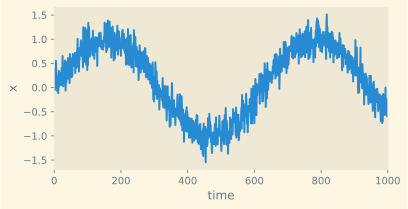

In [219]:
data = Data()
plot(data.time, data.x, "time", "x", xlim=[0, 1000], figsize=(6,3))


In [220]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

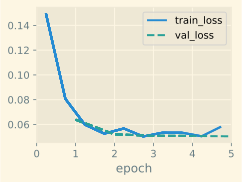

In [221]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

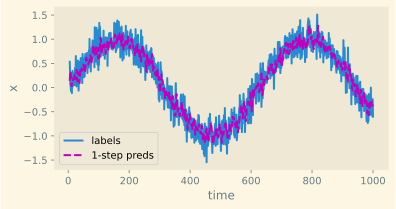

In [222]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

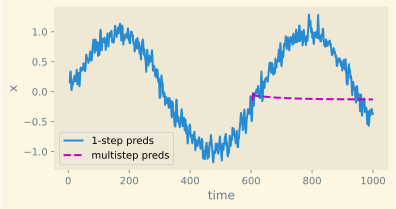

In [223]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
  multistep_preds[i] = model(
      multistep_preds[i-data.tau : i].reshape((1,-1))
  )
  
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

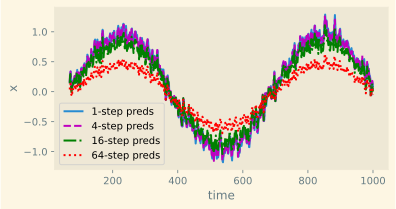

In [224]:
def k_step_pred(k):
  features = []
  for i in range(data.tau):
    features.append(data.x[i : i + data.T - data.tau - k + 1])
  
  for i in range(k):
    preds = model(torch.stack(features[i : i + data.tau], 1))
    features.append(preds.reshape(-1))
  return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))


## **Converting Raw Text into Sequence Data**

In [225]:
class TimeMachine(d2l.DataModule):
  def _download(self):
    fname = d2l.download(d2l.DATA_URL + "timemachine.txt", self.root,
                         "090b5e7e70c295757f55df93cb0a180b9691891a")
    with open(fname) as f:
      return f.read()

In [226]:
data = TimeMachine()
raw_text = data._download()
raw_text[:240]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Traveller (for so it will be convenient to speak of him)\nwas expounding a recondite matter to us. His grey eyes shone and\ntwinkled, and his usually pale face was flushed and animated.'

In [227]:
@add_to_class(TimeMachine)
def _preprocess(self, text):
  return re.sub("[^A-Za-z]+", " ", text).lower()


In [228]:
text = data._preprocess(raw_text)
text[:360]

'the time machine by h g wells i the time traveller for so it will be convenient to speak of him was expounding a recondite matter to us his grey eyes shone and twinkled and his usually pale face was flushed and animated the fire burned brightly and the soft radiance of the incandescent lights in the lilies of silver caught the bubbles that flashed and passed'

In [229]:
@add_to_class(TimeMachine)
def _tokenize(self, text):
  return list(text)



In [230]:
class Vocab:
  def __init__(self, tokens=[], min_freq=0, reserved_words=[]): 
    """Given a list of tokens, construct index_to_token and token_to_idx
    dictionaries. Also constructs a frequency dictionary.
    
    Has __getitem__ and __len__ for ease of use with python's data model.
    
    If a word is not in the vocabulary, returns <unk>"""
    if isinstance(tokens[0], list):
      tokens = [token for line in tokens for token in line]
    counter = collections.Counter(tokens)
    self.token_freqs = sorted(counter.items(), key=lambda x:x[1], reverse=True)
    self.idx_to_token = list(sorted(set(
        ["<unk>"] + reserved_words + 
        [token for (token,freq) in self.token_freqs if freq >= min_freq]
    )))
    self.token_to_idx = {token:idx for (idx, token) in enumerate(self.idx_to_token)}

  def __len__(self):
    return len(self.idx_to_token)
  
  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk)
    return [self.__getitem__(token) for token in tokens] 

  def to_tokens(self, indices):
    if hasattr(indices, "__len__") and len(indices) > 1:
      return [self.idx_to_token[int(index)] for index in indices]
    return self.idx_to_token(indices)

  @property
  def unk(self):
    return self.token_to_idx["<unk>"]  


In [231]:
c = collections.Counter(["a", "b", "c", "a", "a", "c","d"])
sorted(c.items(), key=lambda x:x[1], reverse=True)

[('a', 3), ('c', 2), ('b', 1), ('d', 1)]

In [232]:
tokens = data._tokenize(text)

In [233]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print("indices:", indices)
print("words:", vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [234]:
@add_to_class(TimeMachine)
def build(self, raw_text, vocab=None):
  tokens = self._tokenize(self._preprocess(raw_text))
  if vocab is None: vocab = Vocab(tokens)
  corpus = [vocab[token] for token in tokens]
  return corpus, vocab

In [235]:
corpus, vocab = data.build(raw_text)

In [236]:
len(corpus)

173428

In [237]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

Articles like "the" and "a", pronouns like "i" and "my", and prepositions like "of" and "to" were often filtered out in previous generations of text classifiers based on bag-of-words representations. However, when working with modern RNN and Transformer based NLP models it is not necessary to do so.

Word frequency tends to follow a (Zipfian) power law distribution,  and the $10$th most frequent word is less than $1/5$ as common as the most popular.

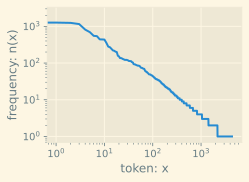

In [238]:
freqs = [freq for token, freq in vocab.token_freqs]

d2l.plot(freqs, xlabel="token: x", ylabel="frequency: n(x)",
         xscale="log", yscale="log")
#plt.plot([0.5 ** (x-15) for x in range(100)])
plt.grid()

Except the most popular words at the beginning, the remaining words follow a straight line on a log-log plot. That is, $\log n_i \approx -\alpha \log i + c$. This means that we will significantly overestimate the frequency of infrequent words if we only model by counting statistics.

In [239]:
bigram_tokens = ["--".join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [240]:
trigram_tokens = ["--".join(triple) for triple in zip(words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:15]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13),
 ('for--a--moment', 12),
 ('said--the--time', 12),
 ('out--of--the', 12),
 ('i--could--see', 12),
 ('a--kind--of', 11)]

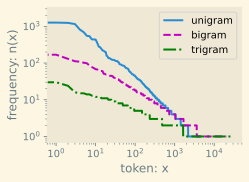

In [241]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

Sequences of words also appear to be following Zipf's law. The number of distinct n-grams is not that large, and many n-grams occur very rarely. This means that certain methods that cannot handle such a skewed distribution are unsuitable for language modelling and so this motivates the use of deep learning models.

## **Language Models**

The goal of *language models* is to estimate the joint probability of the whole sequence $p(x_1,\ldots, x_T)$. An ideal language model would be able to generate natural text on its own, just by drawing one token at a time $x_t \sim P(x_t \mid x_{t-1}, \ldots, x_{1})$. All text emerging from such a model would pass as natural language.

A distribution satisfies markov property of the first order if $P(x_{t+1} \mid x_t, \ldots, x_1) = P(x_{t+1} \mid x_t)$.

We may estimate such conditional probabilities as $\hat{P}(\verb|learning| \mid \verb|deep|) = \frac{n(\verb|deep|, \verb|learning|)}{n(\verb|deep|)}$ where the numerator is the number of occurances of the words as consecutive word pairs. However, there are many plausible word pairs that we will not see in our data set since n-grams follow Zipf's Law.

### **Perplexity**

We will not discuss how to measure the quality of a language model. One way is to check how *surprising* a text is. We might measure the quality of the model by computing the likelihood of the sequence, but this is not a good measure since shorter sequences are much more likely to occur than longer sequences.

We will use information theory instead. A better language model should allow us to spend fewer bits in compressing the sequence, and so must have lower entropy. We measure this by the cross-entropy loss averaged over all the tokens of the sequence: $Z = \frac{1}{n} \sum_{t=1}^{n} - \log P(x_t \mid x_{t-1}, \ldots, x_1)$ where $P$ is given by the language model. In natural language processing, the preferred quantity is $\exp(Z)$ and is called the *perplexity* of the sequence.

### **Partitioning Sequences**

Suppose the dataset takes the form of a sequence of $T$ token indices in a corpus. We will partition it into subsequence, where each subsequence has $n$ tokens. At the beginning of each epoch, we will discard the first $d$ tokens ($d$ is uniformly sampled). The reset of the sequence is partitioned into length $n$ subsequences. The resulting partitioned subsequences will be used as input into the language model.

For language modelling, the goal is to predict the next token based on the tokens seen previously, and so the targets are the original sequence shifted by one token. 

In [242]:
@add_to_class(TimeMachine)
def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
  """num_steps is """
  super(TimeMachine, self).__init__()
  self.save_hyperparameters()
  corpus, self.vocab = self.build(self._download())
  #Corpus is a list encoding the text like [20, 2, 13, 0, 17, 11, 25, ...]
  #num steps is the amount of text we provide the input to predict the next character
  array = torch.tensor([corpus[i:i+num_steps+1]
                        for i in range(0,len(corpus) - num_steps - 1)])
  self.X, self.Y = array[:, :-1], array[:, 1:]

In [243]:
@add_to_class(TimeMachine)
def get_dataloader(self, train):
  if train:
    idx = slice(0, self.num_train)
  else:
    idx = slice(self.num_train, self.num_train + self.num_val)
  
  return self.get_tensorloader([self.X, self.Y], train, idx)

  

In [244]:
data = TimeMachine(batch_size=2, num_steps=10)
for X,Y in data.train_dataloader():
  print(f"X: {X} \n ************ \n Y: {Y}  ")
  break

X: tensor([[ 0,  4, 19,  2,  5, 13,  6,  0, 21, 16],
        [ 0, 10, 21,  0, 24,  2, 20,  0, 20, 16]]) 
 ************ 
 Y: tensor([[ 4, 19,  2,  5, 13,  6,  0, 21, 16,  0],
        [10, 21,  0, 24,  2, 20,  0, 20, 16,  0]])  


## **Recurrent Neural Networks**

Instead of modelling Markov models and n-grams, we prefer to use a latent variable model with a hidden state $h_{t-1}$. Thus we attempt to model $P(x_t \mid h_{t-1})$ where $h_t = f(x_t, h_{t-1})$. 

*Recurrent neural networks* are neural networks with hidden states.

### **Recurrent Neural Networks with Hidden States**

If we have a minibatch of inputs $X_t$ and a hidden layer output $H_t$ at time $t$, then the calculation of the hidden layer output is given by: $$H_t = \phi(X_tW_{xh} + H_{t-1}W_{hh} + b_{h})$$ Such a hidden layer output is called a *hidden state*.



The computation of the output layer at time $t$ is similar to the computation in an MLP: $O_t = H_t W_{hq} + b_q$.



RNNs use the same parameters in different time steps. 

## **Recurrent Neural Networks from Scratch**





In [245]:
class RNNScratch(Module):
  def __init__(self, num_inputs, num_hiddens, sigma=0.01):
    """num_inputs is the length of the vocabulary
    as any character will be encoded as a 1-hot vector.
    For eg. W_xh has shape num_inputs x num_hiddens
    """
    super().__init__()
    self.save_hyperparameters()
    self.W_xh = nn.Parameter(
        torch.randn(num_inputs, num_hiddens) * sigma
    )
    self.W_hh = nn.Parameter(
        torch.randn(num_hiddens, num_hiddens) * sigma
    )
    self.b_h = nn.Parameter(torch.zeros(num_hiddens))

  def forward(self, inputs, state=None):
    if state is not None:
      state, = state
    outputs = []

    #shape of inputs is num_steps, batch_size, num_inputs
    for X in inputs:
      if state is not None:
        state = torch.tanh(X @ self.W_xh + state @ self.W_hh + self.b_h)
      else:
        state = torch.tanh(X @ self.W_xh + self.b_h)
      outputs.append(state)

    return outputs, state

In [246]:
def check_len(a, n):  #
    assert len(a) == n, f'list\'s len {len(a)} != expected length {n}'

def check_shape(a, shape):  #
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'



In [247]:
class RNNLMScratch(Classifier):
  def __init__(self, rnn, vocab_size, lr=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.init_params()

  
  def init_params(self):
    self.W_hq = nn.Parameter(
        torch.randn(self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma
    )
    self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

  def training_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    self.plot("perplexity", torch.exp(l), train=True)
    return l

  def validation_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    self.plot("perplexity", torch.exp(l), train=False)

In [248]:
F.one_hot(torch.tensor([0,2,3,1]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0]])

In [249]:
@add_to_class(RNNLMScratch)
def one_hot(self, x):
  #Output shape: (num_steps, batch_size, vocab_size)
  return F.one_hot(x.T, self.vocab_size).type(torch.float32)

In [250]:
@add_to_class(RNNLMScratch)
def output_layer(self, rnn_outputs):
  outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
  return torch.stack(outputs, 1)

In [251]:
@add_to_class(RNNLMScratch)
def forward(self, x, state=None):
  embs = self.one_hot(x)
  rnn_outputs, _ = self.rnn(embs, state)
  return self.output_layer(rnn_outputs)

In [252]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X31 = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X31)

In [253]:
check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

In [254]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
d2l.check_shape(outputs, (batch_size, num_steps, num_inputs))

### **Gradient Clipping**

Dealing with vanishing and exploding gradients is a fundamental problem when designing RNNs. One inelegant but ubiquitous solution is to clip gradients, forcing them to take smaller values. We replace a gradient $\mathbf{g}$ by $\min\left(1, \frac{\theta}{\lvert \mathbf{g}\rvert}\right) \mathbf{g}$. This ensures that the updated gradient is aligned with the original direction of $\mathbf{g}$.

In [255]:
@add_to_class(Trainer)
def clip_gradients(self, grad_clip_val, model):
  params = [p for p in model.parameters() if p.requires_grad]
  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
  if norm > grad_clip_val:
    for param in params:
      param.grad[:] *= grad_clip_val / norm

In [256]:
%%script echo skipping

data = TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

skipping


### **Decoding**

Once a language model has been learned, we can use it to predict multiple tokens by treating a previously generated token as if it were the next token in the input. We will give the model a user provided prefix and the model will first ingest the prefix without providing any output. This is called the *warmup* period. 

In [269]:
@add_to_class(RNNLMScratch)  
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict `num_preds` steps
            Y = self.output_layer(rnn_outputs)
            #X has shape num_step x batch_size x num_vocab
            #Y has shape num_step x batch_size x num_vocabe
            #There is only one step and one batch, so we collapse
            #dimensions after doing num vocab


            outputs.append(int(Y.argmax(axis=2).reshape(1))) #choose index with highest softmax prob in a tensor of shape 1x1xv
            
    return ''.join([vocab.idx_to_token[i] for i in outputs])

"i" "t" " " "h" "a" "s"

[10, 21, 0, 9, 2, 20]

X = [[10]] here we have 1 token and 1 batch
and we are passing the hidden vector around for the whole sentence
since we cannot input an incomplete sentence. We would input one token
at a time (or maybe multiple at once) and then we would pass the hidden
vector. That is why we return the hidden vector.

`self.rnn` expects X of shape `num_tokens x batch_size x num_vocab`

In [258]:
%%script echo skipping


data = TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab),num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = Trainer(max_epochs=100, num_gpus=1, gradient_clip_val=1)
trainer.fit(model, data)

skipping


In [259]:
%%script echo skipping


model.predict(prefix="our glasses", num_preds=100, vocab=data.vocab, device=d2l.try_gpu())

skipping


## **Concise Implementation of Recurrent Neural Networks**

In [260]:
class RNN(Module):
  def __init__(self, num_inputs, num_hiddens):
    """num_inputs is the size of the vocabulary.
    For eg. W_xh has shape num_inputs x num_hiddens"""
    super().__init__()
    self.save_hyperparameters()
    self.rnn = nn.RNN(num_inputs, num_hiddens)

  def forward(self,inputs, H=None):
    return self.rnn(inputs, H)

In [261]:
class RNNLM(RNNLMScratch):
  def init_params(self):
    self.linear = nn.LazyLinear(self.vocab_size)

  def output_layer(self, hiddens):
    return self.linear(hiddens).swapaxes(0,1) #why are we swapping axes? We might want the batch axis first, since we 
    #treat the num_steps x num_vocab matrix for a batch as the actual output which we compare with the expected by
    #the perplexity loss function

In [262]:
%%script echo skipping

data = TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
trainer = Trainer(max_epochs=100, num_gpus=1, gradient_clip_val=1)
trainer.fit(model, data)

skipping


In [263]:
%%script echo skipping

model.predict('it has', 50, data.vocab, d2l.try_gpu())

skipping


## **Backpropogation Through Time**

We unroll the computational graph of an RNN one seqeuence step at a time. However, complications arise because sequences can be long. Inputs from the first step passes through over 1000 matrix products before arriving at the output, and the backward pass needs another 1000 matrix products.

One solution is to truncate the backward pass after $\tau$ steps. This leads to an approximation of the true gradient, and works quite well in practice. One consequence is that the model focuses primarily on short term influence rather than long term consequences. This is desireable since it biases the estimate towards simpler and more stable models.

Another solution is to replace the problematic $\frac{\partial h_t}{\partial w_h}$ term by a random variable which is correct in expectation but truncates the sequence. This is achieved by using a sequence $\xi_t$ with predefined $0 \leq \pi_t \leq 1$ where $P(\xi_t = 0) = 1 - \pi_t$ and $P(\xi_t = \pi_t^{-1}) = \pi_t$. So we replace $\frac{\partial h_t}{\partial w_h}$ with $\frac{\partial f(x_t, h_{t-1}, w_h)}{\partial w_h} + \xi_t \frac{\partial f(x_t, h_{t-1}, w_h)}{\partial h_{t-1}}\frac{\partial h_{t-1}}{\partial w_h}$.

However, randomized truncation doesn't work much better than regular truncation in practice. 

# **Chapter 10: Modern Recurrent Neural Networks**

In practice, gated RNNs are much more common in practice due to the numerical instability of vanilla RNNs.

## **Gated Recurrent Units (GRU)**

In RNNs, we found that long products of matrices can lead to vanishing or exploding gradients and so we needed to truncate the backpropogation pass. This lead to RNNs being more focused on recent history.

However, we would like to be able to store some early information in a *memory cell* if need be and also ignore intermediate cells if they serve no purpose (for example, auxiliary HTML code when parsing sentiment of a webpage). Also, we would like to be able to handle situations where there is a logical break betwen parts of a sequence (transition between chapters of a book, for example). In such a situation, we might want to reset our internal state representation.

A number of methods have been proposed to address this. Two of these are LSTMs (Long Short Term Memory) and GRUs (Gated Recurrence Units)

### **Gated Hidden States**

GRUs support gating of the hidden state. This means that we have dedicated mechanisms for when the hidden state should be *updated* and when it should be *reset*. These mechanisms are learned.

For example, if the first token is important, the unit will learn to not update the hidden state after the first observation.

GRUs have *reset* and *update* gates. These are vectors with entries in $(0,1)$ such that we can perform convex combinations. The outputs of the two gates are given by two fully connected layers with a sigmoid activation function.

Mathematically, if the input at time $t$ is $X_t$ and the hidden state is $H_{t}$, then the reset gate $R_t$ and update gate $Z_t$ are computed as $$R_t = \sigma(X_t W_{xr} + H_{t-1}W_{hr} + b_r)$$ and $$Z_t = \sigma(X_tW_{xz} + H_{t-1}W_{hz} + b_z)$$ where $W_{xr}, W_{xz} \in \mathbb{R}^{d \times h}$ and $W_{hr}, W_{hz} \in \mathbb{R}^{h \times h}$.

We have the *candidate hidden state* $$\tilde{H}_t = \tanh(X_t W_{xh} + (R_t \odot H_{t-1})W_{hh} + b_h)$$ and finally, the actual hidden state $$H_t = Z_t \odot H_{t-1} + (1-Z_t) \odot \tilde{H}_t$$

In [264]:
class GRUScratch(Module):
  def __init__(self, num_inputs, num_hiddens, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()

    init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
    triple = lambda : (init_weight(num_inputs, num_hiddens),
                       init_weight(num_hiddens, num_hiddens),
                       nn.Parameter(torch.zeros(num_hiddens)))
    self.W_xz, self.W_hz, self.b_z = triple()
    self.W_xr, self.W_hr, self.b_r = triple()
    self.W_xh, self.W_hh, self.b_h = triple()
  
  def forward(self, inputs, H=None):
    hidden_state_outputs = []
    for X in inputs: #time step
      if H is not None: 
        R = torch.sigmoid(X @ self.W_xr + H @ self.W_hr + self.b_r)
        Z = torch.sigmoid(X @ self.W_xz + H @ self.W_hz + self.b_z)

        H_tilde = torch.tanh(X @ self.W_xh + (R * H) @ self.W_hh + self.b_h)
        H = Z * H + (1-Z) * H_tilde
      else: #The first time
        R = torch.sigmoid(X @ self.W_xr + self.b_r)
        Z = torch.sigmoid(X @ self.W_xz + self.b_z)
        H_tilde = torch.tanh(X @ self.W_xh + self.b_h)
        H = (1-Z) * H_tilde

      hidden_state_outputs.append(H)
    
    return hidden_state_outputs, (H,)
                                                                                                        

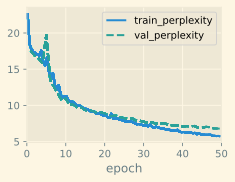

In [265]:
%%script echo skipping

data = TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [266]:
class GRU(RNN):
  def __init__(self, num_inputs, num_hiddens):
    Module.__init__(self)
    self.save_hyperparameters()
    self.rnn = nn.GRU(num_inputs, num_hiddens)

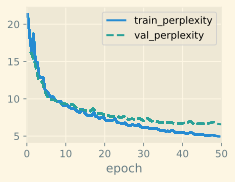

In [267]:
%%script echo skipping

gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [272]:
%%script echo skipping
model.predict('it has', 100, data.vocab, d2l.try_gpu())

skipping


## **Long Short-Term Memory (LSTM)**

LSTM introduces a memory cell that has the same shape as the hidden state to record information. To control the memory cell we use a number of gates: the *output gate* to read out entries from the cell, the *input gate* to decide when to read data into the cell, the *forget gate* which decides to reset the content of the cell.   